# 
<p align="center">
  <b><font size="8"> Project description</font></b>
</p>

The purpose here is to use a time series dataset on COVID 19 in $\mathbb{F}$ rance to demonstrate how we can:

- Manipulate a dataset  
- Identify missing data  
- Clean a dataset properly  
- Impute missing data using different methods  
- Evaluate these methods  


In [ ]:
# Import the libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.interpolate import interp1d

In [ ]:
# import the dataset 
df = pd.read_csv('Covid_France.csv')

Start with data manipulation

In [147]:
# Select only the headers (columns names)
columns = df.columns.values.tolist()

# Inverse the list
columns_inverse = columns[::-1]

# Create a new DataFrame with the inverted columns
df_inverse = pd.DataFrame(columns=columns_inverse)

# Fill the new DataFrame with the values from the original DataFrame
for col in columns:
    df_inverse[col] = df[col]
    
# Display the percentage of missing values in each column
nan_values = df_inverse.isna().sum()/len(df_inverse)*100
print("Percentage of NaN values per columns in df_inverse (and in df by extension):")
print(nan_values)

# display the highest percentage of missing values
print()
print("Highest percentage of NaN values:", round(nan_values.max(),2), "for the feature '",nan_values.idxmax(),"'.")

Percentage of NaN values per columns in df_inverse (and in df by extension):
nouveaux_patients_reanimation      2.106568
nouveaux_patients_hospitalises     2.106568
total_patients_gueris              1.734820
patients_hospitalises              1.734820
patients_reanimation               0.743494
total_cas_possibles_ehpad         98.141264
total_cas_confirmes_ehpad         61.214374
total_deces_ehpad                  3.965304
total_deces_hopital                0.000000
total_cas_confirmes               56.257745
date                               0.000000
dtype: float64

Highest percentage of NaN values: 98.14 for the feature ' total_cas_possibles_ehpad '.


Now that missing data is identified and quantified, let's begin the cleaning process.

In [ ]:
# compare the dimensions of the raw version of df and a cleaned version, without NaN
df_cleaned = df.dropna()
print("Dimensions of df_cleaned:", df_cleaned.shape)
print(f"Dimensions of Df {df.shape} with NaN values")
print(f"Loss of data {(df.shape[0] - df_cleaned.shape[0])/df.shape[0]*100:.2f}%")
 

Dimensions of df_cleaned: (15, 11)
Dimensions of Df (807, 11) with NaN values
Loss of data 98.14%


Such amount of lost data is unacceptable, therefore another cleaning method will be needed.

In [149]:
# In order to spare some time, we will transform the code into a 2 entries function
def size_comparison(df1, df2):
    """Compare the dimensions of two DataFrames and print the loss of data.

    Args:
        df1: Pandas DataFrame to compare (original size).
        df2: Pandas DataFrame to be compared (cleaned size).
    """
    origin_shape = df1.shape
    reduced_shape = df2.shape
    loss = 0
    total_relevant_data1 = df1.count().sum()
    total_relevant_data2 = df2.count().sum()

    if origin_shape[0] != reduced_shape[0]: 
        loss = (origin_shape[0] - reduced_shape[0]) / origin_shape[0] * 100
        print(f"Dimensions of the original DataFrame: {origin_shape}")
        print(f"Dimensions of the cleaned DataFrame: {reduced_shape}")
        print(f"There is a loss of {loss:.2f}% of data after cleaning.")
    
    if origin_shape[1] != reduced_shape[1]: 
        diff_column = (origin_shape[1] - reduced_shape[1])
        loss = (total_relevant_data1 - total_relevant_data2) / total_relevant_data1 * 100
        print(f"Dimensions of the original DataFrame: {origin_shape}")
        print(f"Dimensions of the cleaned DataFrame: {reduced_shape}")
        print(f"There is a loss of {diff_column} columns after cleaning,")
        print("which corresponds to a loss of", round(loss,2), "% of data.")
    else:
        print("The two DataFrames have the same dimensions.")

Ehpad variables are messing with our data, and in regard of the NaN percentage, we would benefit from removing these columns. 

In [150]:
# remove Ehpad related columns 
df_cleaned = df.drop(columns=['total_cas_possibles_ehpad','total_cas_confirmes_ehpad'])

# compare the dimensions of the raw version of df and a cleaned version, without NaN
size_comparison(df, df_cleaned)

Dimensions of the original DataFrame: (807, 11)
Dimensions of the cleaned DataFrame: (807, 9)
There is a loss of 2 columns after cleaning,
which corresponds to a loss of 4.66 % of data.


This data loss under 5% is more acceptable.

In [151]:
df_cleaned_percent = df_cleaned.isna().sum()/len(df_cleaned)*100
print("Percentage of NaN values per columns in df_cleaned:")
print(df_cleaned_percent)

Percentage of NaN values per columns in df_cleaned:
date                               0.000000
total_cas_confirmes               56.257745
total_deces_hopital                0.000000
total_deces_ehpad                  3.965304
patients_reanimation               0.743494
patients_hospitalises              1.734820
total_patients_gueris              1.734820
nouveaux_patients_hospitalises     2.106568
nouveaux_patients_reanimation      2.106568
dtype: float64


In [ ]:
# visualize the data
df_bis = df_cleaned.dropna(axis=1, how='all')
df_bis['date'] = pd.to_datetime(df_bis['date'], format='%Y-%m-%d')

plt.figure(figsize=(10, 6))
plt.plot(df_bis['date'], df['total_cas_confirmes'])
# Set the x-axis major locator and formatter
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Date (YYYY-MM-DD)')
plt.ylabel('Total confirmed cases')
plt.title('Total confirmed cases over time')
plt.show()

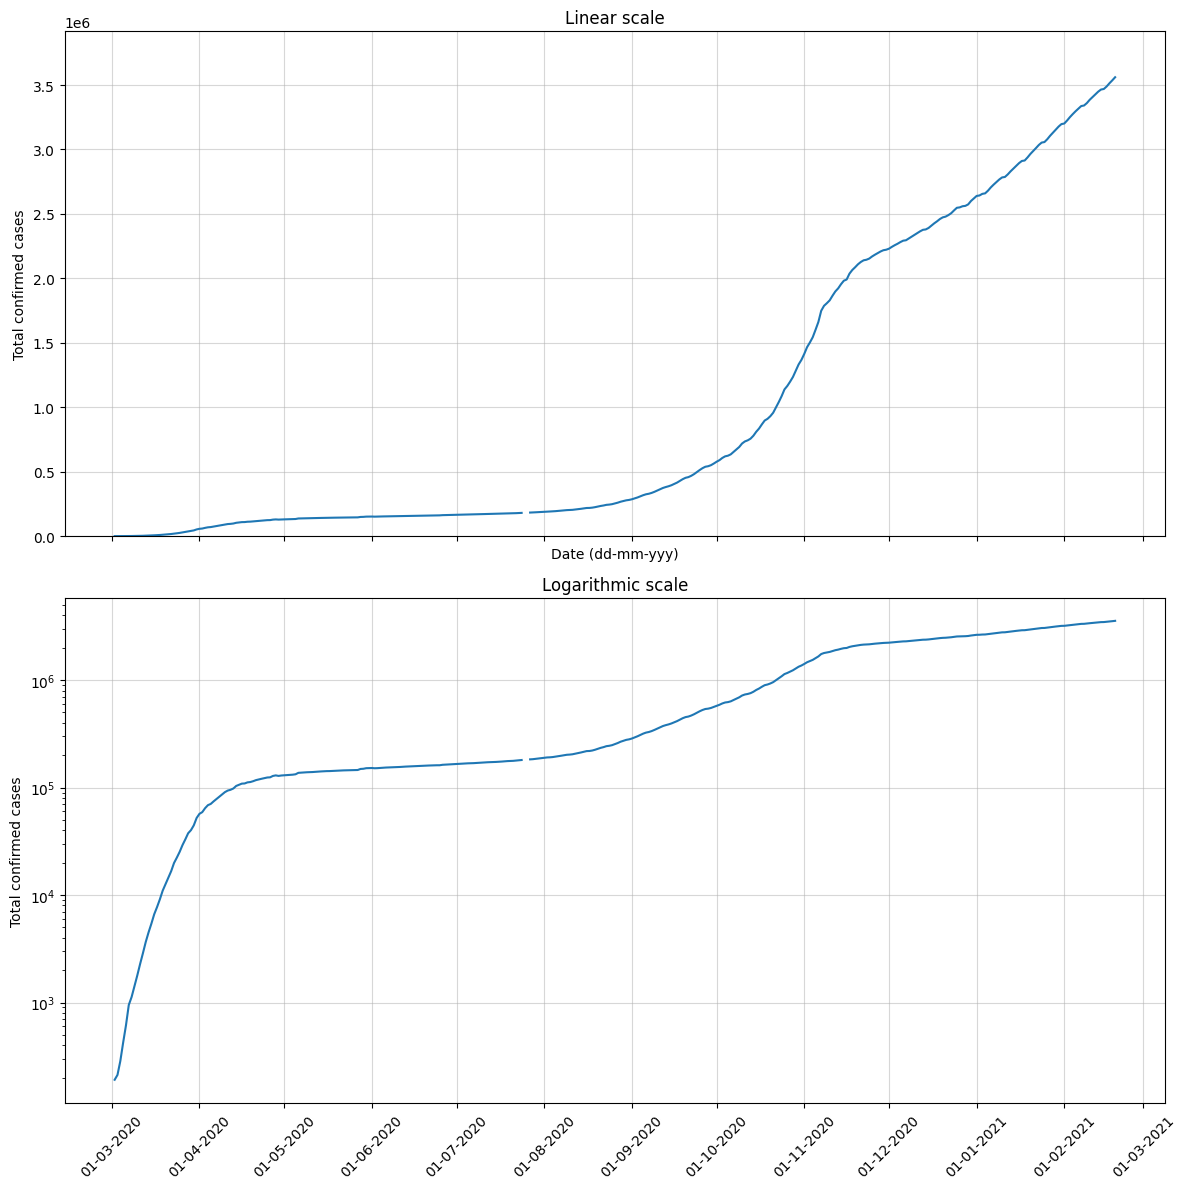

In [154]:
# We would like to have multiple scales for comparison
fig, axes = plt.subplots(2,1, figsize=(12, 12), sharex=True)

# First plot with linear scale
axes[0].plot(df_bis['date'], df['total_cas_confirmes'])
axes[0].set_yscale('linear')
axes[0].set_ylim(0, df['total_cas_confirmes'].max()*1.1)  # Set y-axis limits to avoid cutting the graph
axes[0].set_title('Linear scale')
axes[0].set_xlabel('Date (dd-mm-yyy)')
axes[0].set_ylabel('Total confirmed cases')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha = 0.5)

# Second plot, with logarithmic scale
axes[1].plot(df_bis['date'], df['total_cas_confirmes'])
axes[1].set_yscale('log')
axes[1].set_title('Logarithmic scale')
axes[1].set_ylabel('Total confirmed cases')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

From these graphs, we observe that some data is missing. We will try to fill it with the adequate value. 

For this we will use the following techniques: 

* Moving Average
* Backward Moving Average
* Interpolation
* Local regression (LOESS / LOWESS)
* Forward / backward fill

In [155]:
# First, we notice that the graphs have stopped at 2021-02-01, 
# which is not the last date available in the dataset, maybe a 
# part of 'total_cas_confirmes' is missing.

# Count the number of total_cas_confirmes missing since 01-02-2021
missing_dates = df_bis[df_bis['total_cas_confirmes'].isna()]['date']
missing_dates = missing_dates[missing_dates >= '2021-02-01']

len_missing = len(missing_dates)
len_2021 = len(df_bis[df_bis['date']>='01-02-2021'])

if len_missing < len_2021: 
    print(f"There is/are {len_2021-len_missing} date(s) with total_cas_confirmes missing since 01-02-2021, out of {len_missing} dates.")
    print(f"This means there is {len_missing/len_2021*100:.2f}% of dates with total_cas_confirmes missing since 01-02-2021.")
else:
    print("There is no confirmed cases since 01-02-2021.")


There is/are 49 date(s) with total_cas_confirmes missing since 01-02-2021, out of 452 dates.
This means there is 90.22% of dates with total_cas_confirmes missing since 01-02-2021.


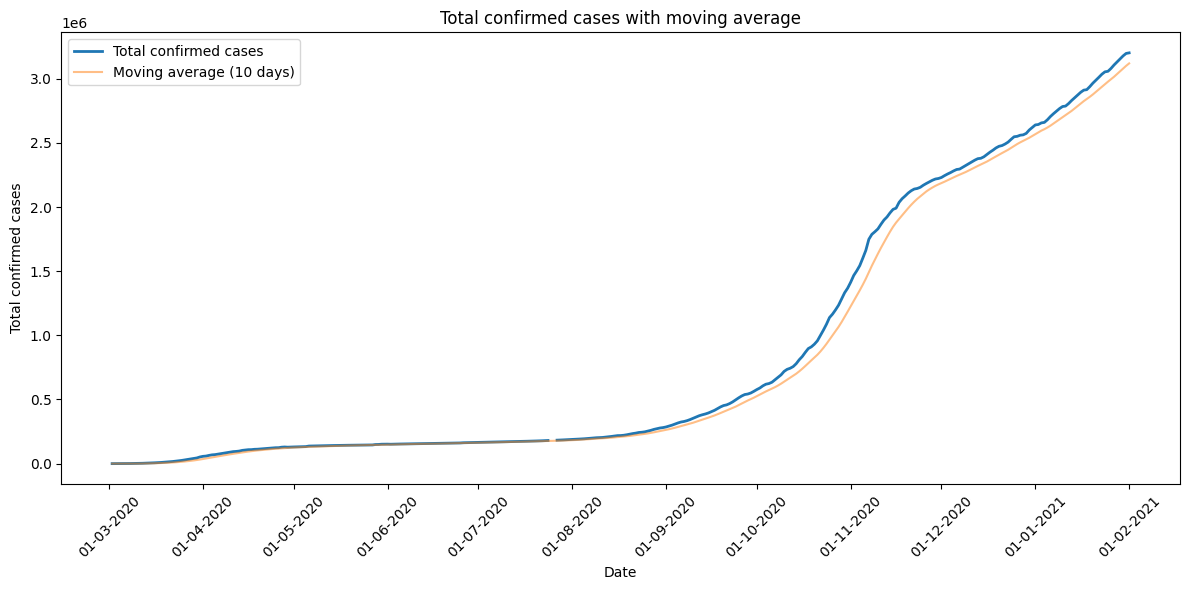

In [156]:
# Moving average
# for the moment, we will only select data from 2020-03-01 to 2021-02-01
mv_avg = df_bis.copy()
mv_avg = mv_avg[(mv_avg['date'] >= '2020-03-01') & (mv_avg['date'] <= '2021-02-01')]

# 1: create a moving average column, with min_periods = 1, 
# meaning that if there is at least one value, the mean will be calculated.
window_size = 10 

mv_avg['moving_average'] = mv_avg['total_cas_confirmes'].rolling(window=window_size, min_periods=1).mean()

# 2: replace the missing values in 'total_cas_confirmes' with the moving average
mv_avg['total_cas_confirmes_filled'] = mv_avg['total_cas_confirmes'].fillna(mv_avg['moving_average'])

# 3: In order to smooth the results, we will apply a moving average 
# on the 'total_cas_confirmes' column once again.
mv_avg['moving_average'] = mv_avg['total_cas_confirmes_filled'].rolling(window=window_size, min_periods=1).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(mv_avg['date'], mv_avg['total_cas_confirmes'], label='Total confirmed cases', linewidth=2)
plt.plot(mv_avg['date'], mv_avg['moving_average'], label='Moving average (10 days)', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Total confirmed cases")
plt.title("Total confirmed cases with moving average")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


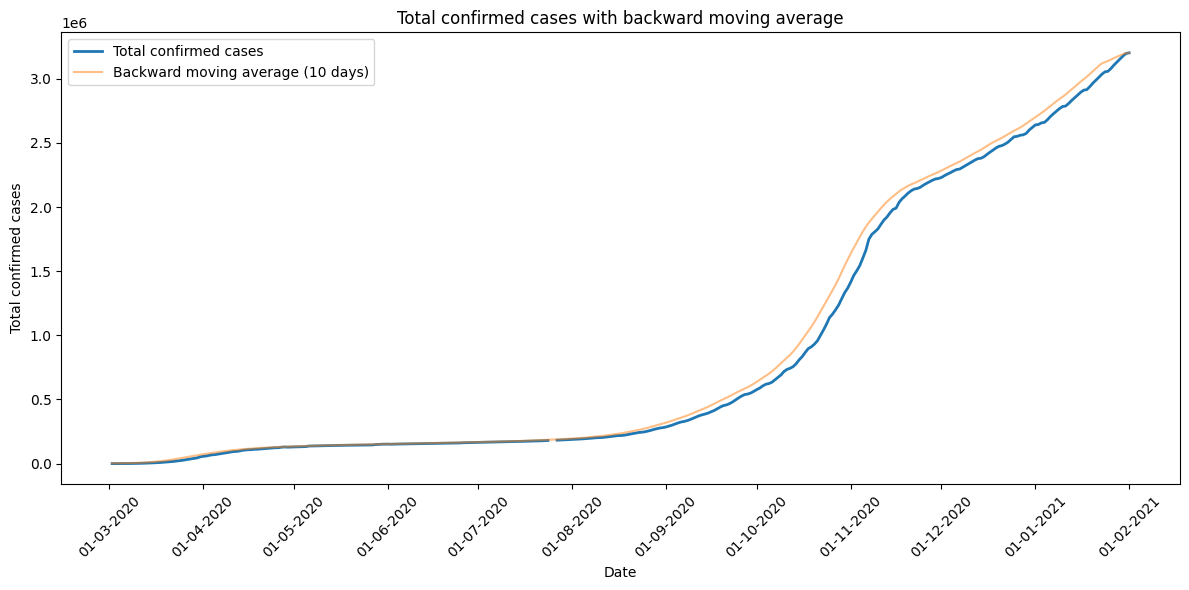

In [157]:
# 1: create a backward moving average column, with min_periods = 1,
# meaning that if there is at least one value, the mean will be calculated
mv_avg['moving_average_b'] = mv_avg['total_cas_confirmes']\
    .shift(-window_size + 1)\
    .rolling(window=window_size, min_periods=1)\
    .mean()

# 2: replace the missing values in 'total_cas_confirmes' with the backward moving average
mv_avg['total_cas_confirmes_filled_b'] = mv_avg['total_cas_confirmes'].fillna(mv_avg['moving_average_b'])

# 3: recalculate the backward moving average on the filled data
mv_avg['moving_average_b'] = mv_avg['total_cas_confirmes_filled_b']\
    .shift(-window_size + 1)\
    .rolling(window=window_size, min_periods=1)\
    .mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(mv_avg['date'], mv_avg['total_cas_confirmes'], label='Total confirmed cases', linewidth=2)
plt.plot(mv_avg['date'], mv_avg['moving_average_b'], label='Backward moving average (10 days)', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Total confirmed cases")
plt.title("Total confirmed cases with backward moving average")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Comparaison

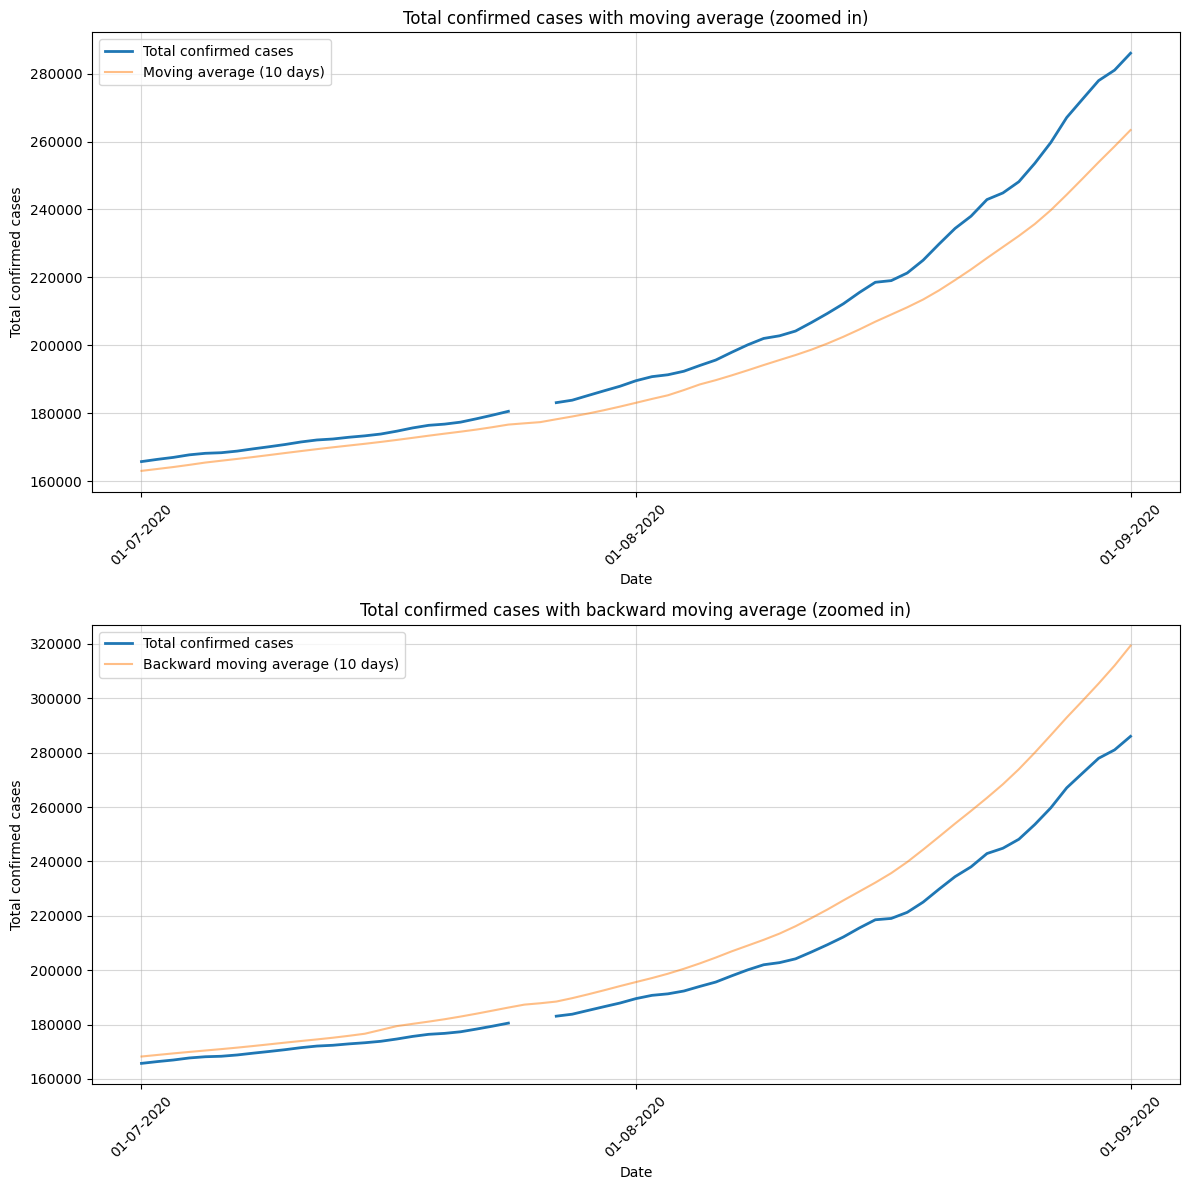

In [ ]:
# create 2 zoomed in subplots. 
mv_avg_zoom = mv_avg[(mv_avg['date'] >= '2020-07-01') & (mv_avg['date'] <= '2020-09-01')]

fig, axes = plt.subplots(2,1, figsize=(12, 12))

# subplot 1: Moving average
axes[0].plot(mv_avg_zoom['date'], mv_avg_zoom['total_cas_confirmes'], label='Total confirmed cases', linewidth=2)
axes[0].plot(mv_avg_zoom['date'], mv_avg_zoom['moving_average'], label='Moving average (10 days)', alpha=0.5)
axes[0].set_xlabel("Date")
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title("Total confirmed cases with moving average (zoomed in)")
axes[0].set_ylabel("Total confirmed cases")
axes[0].legend()
axes[0].grid(True, alpha=0.5)

# subplot 2: Backward moving average
axes[1].plot(mv_avg_zoom['date'], mv_avg_zoom['total_cas_confirmes'], label='Total confirmed cases', linewidth=2)
axes[1].plot(mv_avg_zoom['date'], mv_avg_zoom['moving_average_b'], label='Backward moving average (10 days)', alpha=0.5)
axes[1].set_xlabel("Date")
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title("Total confirmed cases with backward moving average (zoomed in)")
axes[1].set_ylabel("Total confirmed cases")
axes[1].legend()
axes[1].grid(True, alpha=0.5)

plt.tight_layout()  
plt.show()




Visually, we can assume that the moving average is better at its job, but lets quatify the distance between the smoothed values and the true values. 

In [ ]:
# quantify the quality of the moving average using MSE
mse = mean_squared_error(mv_avg_zoom['total_cas_confirmes_filled'], mv_avg_zoom['moving_average'])
mse_b = mean_squared_error(mv_avg_zoom['total_cas_confirmes_filled_b'], mv_avg_zoom['moving_average_b'])
print(f"MSE of the moving average: {mse:.2f}")
print(f"MSE of the backward moving average: {mse_b:.2f}")
if mse < mse_b:
    print("The moving average is better than the backward moving average.")
else:
    print("The backward moving average is better than the moving average.")

MSE of the moving average: 102889016.22
MSE of the backward moving average: 185213010.46
The moving average is better than the backward moving average.


C:\Users\guigu\AppData\Local\Temp\ipykernel_17088\3422486039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpolated_zoom['total_cas_confirmes_interpolate'] = df_interpolated_zoom['total_cas_confirmes'].interpolate(method='linear')


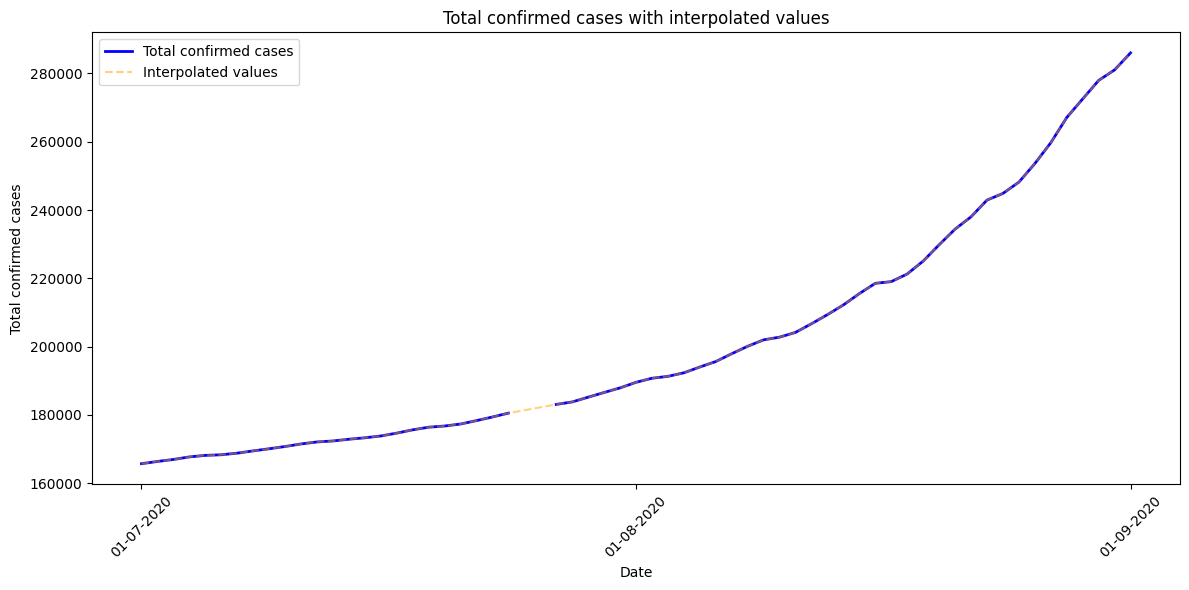

In [160]:
# Interpolation method
df_interpolated = df_bis.copy()
df_interpolated_zoom = df_interpolated[(df_interpolated['date'] >= '2020-07-01') & (df_interpolated['date'] <= '2020-09-01')]

# Use liner interpolation to fill the missing values
df_interpolated_zoom['total_cas_confirmes_interpolate'] = df_interpolated_zoom['total_cas_confirmes'].interpolate(method='linear')

# plot the total_cas_confirmes and the interpolated values
plt.figure(figsize=(12, 6))
plt.plot(df_interpolated_zoom['date'], df_interpolated_zoom['total_cas_confirmes'], label='Total confirmed cases', linewidth=2, color='blue')
plt.plot(df_interpolated_zoom['date'], df_interpolated_zoom['total_cas_confirmes_interpolate'], label='Interpolated values', alpha=0.5, color='orange', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total confirmed cases")
plt.title("Total confirmed cases with interpolated values")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

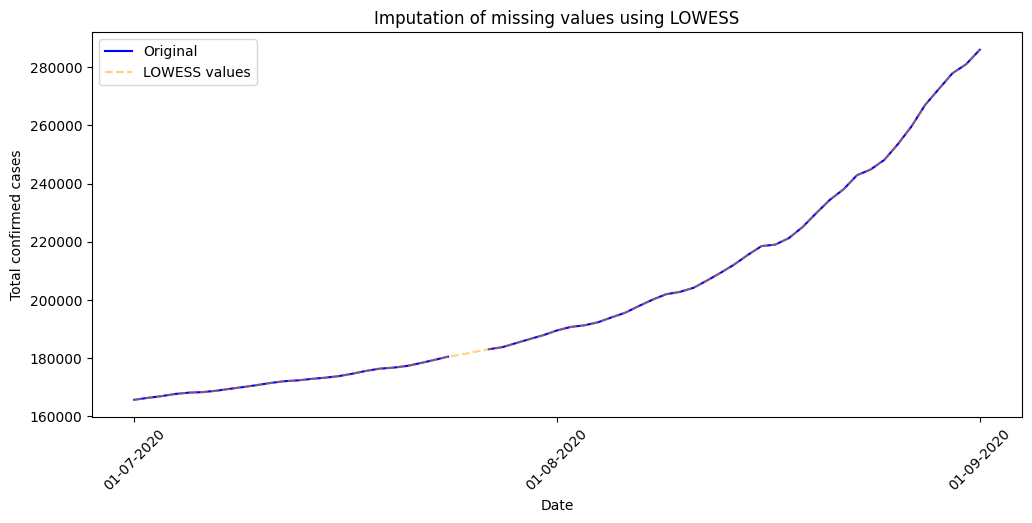

In [ ]:
# Copie et filtrage
df_lowess = df_bis.copy()
df_lowess = df_lowess[(df_lowess['date'] >= '2020-07-01') & (df_lowess['date'] <= '2020-09-01')].copy()

# Dates -> ordinals
df_lowess['date_ord'] = df_lowess['date'].map(pd.Timestamp.toordinal)

# Supprimer les NaN pour appliquer LOWESS
df_nonan = df_lowess.dropna(subset=['total_cas_confirmes'])

# LOWESS
lowess_result = sm.nonparametric.lowess(
    endog=df_nonan['total_cas_confirmes'],
    exog=df_nonan['date_ord'],
    frac=0.1
)

# Extraire les x et y du lissage
x_lowess = lowess_result[:, 0]
y_lowess = lowess_result[:, 1]

# Créer une fonction d'interpolation basée sur le LOWESS
f_interp = interp1d(x_lowess, y_lowess, kind='linear', fill_value='extrapolate')

# Appliquer l'interpolation à toutes les dates (y compris celles avec NaN)
df_lowess['lowess_filled'] = f_interp(df_lowess['date_ord'])

# Remplacer uniquement les NaN dans la colonne originale
df_lowess['total_cas_lowess_imputed'] = df_lowess['total_cas_confirmes']
df_lowess.loc[df_lowess['total_cas_confirmes'].isna(), 'total_cas_lowess_imputed'] = df_lowess['lowess_filled']

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_lowess['date'], df_lowess['total_cas_confirmes'], label='Original', color='blue')
plt.plot(df_lowess['date'], df_lowess['total_cas_lowess_imputed'], label='LOWESS values', linestyle='--', color='orange', alpha=0.5)
plt.legend()
plt.title("Imputation of missing values using LOWESS")
plt.xlabel("Date")
plt.ylabel("Total confirmed cases")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()


Linear interpolation is an efficient and simple method for estimating missing values when they are few and scattered. It works by connecting two known points with a straight line, making it ideal for datasets with minimal noise and small gaps. 


However, when the data is noisy or exhibits non-linear trends, linear interpolation may not capture the underlying patterns accurately. 


In such cases, LOWESS (Locally Weighted Scatterplot Smoothing) is more appropriate. It performs local regressions around each point using nearby data, allowing it to smooth out short-term fluctuations while preserving the overall structure. This makes LOWESS especially useful for time series with irregularities or when visualizing long-term trends in the presence of noise

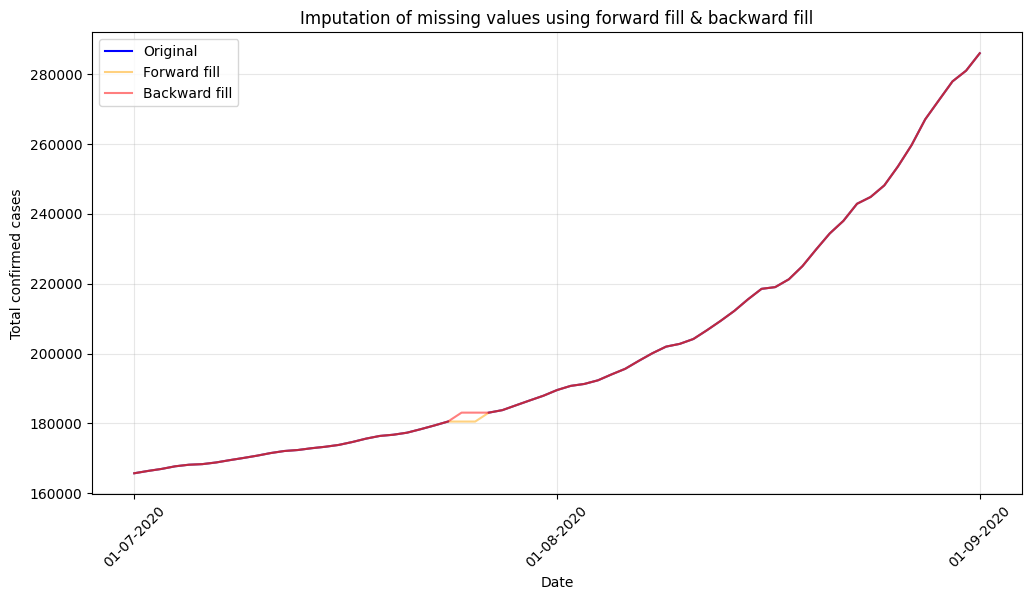

In [162]:
# Forward fill & backwardfill

df_fill = df_bis.copy()
df_fill = df_fill[(df_fill['date'] >= '2020-07-01') & (df_fill['date'] <= '2020-09-01')]

# forward fill
df_fill['total_cas_confirmes_ffill']= df_fill['total_cas_confirmes'].ffill()

# backward fill
df_fill['total_cas_confirmes_bfill'] = df_fill['total_cas_confirmes'].bfill()

# plot the true values, the ffill and bfill imputed values on the same graph
plt.figure(figsize=(12, 6))

plt.plot(df_fill['date'], df_fill['total_cas_confirmes'], label='Original', color='blue')
plt.plot(df_fill['date'], df_fill['total_cas_confirmes_ffill'], label ='Forward fill', color = 'orange', alpha=0.5)
plt.plot(df_fill['date'], df_fill['total_cas_confirmes_bfill'], label='Backward fill', color='red', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Total confirmed cases")
plt.title("Imputation of missing values using forward fill & backward fill")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### <span style='color:Green'>Conclusion:</span>

It appears all methods are playing their role as a way to impute missing data. 

As per human eyes, the `Linear interpolation` and the `LOESS/LOWESS`are the best way to fill the missing values in the time serie.

<span style='color:red'>However</span>, we will conduct a more mathematical investigation and quantify this. 

For this we will create 2 sub datasets, one `test dataset` without missing values, and one `train dataset`, which will be a duplicate of the test one but random missing values.

Then we will apply all 5 methods to the `train dataset`, and evaluate their accuracy using the `MSE` metric. 

In [163]:
# split the data into train and test sets
df_train = df[df['date'] < '2020-07-01'].copy()
df_test = df[df['date'] < '2020-07-01'].copy()
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# add random NaN values to the train set
nan_indices = np.random.choice(df_train.index, size=int(len(df_train)*0.1), replace=False)
df_train.loc[nan_indices, 'total_cas_confirmes'] = np.nan

# fill the NaN values in the train set using the moving average
window_size = 10 
df_train['mv_avg'] = df_train['total_cas_confirmes'].fillna(df_train['total_cas_confirmes'].rolling(window=window_size, min_periods=1).mean())

# fill the NaN values in the train set using the backward moving average
df_train['mv_avg_b'] = df_train['total_cas_confirmes'].fillna(
    df_train['total_cas_confirmes']
    .shift(-window_size + 1)
    .rolling(window=window_size, min_periods=1)
    .mean())

# fill the NaN values in the train set using the linear interpolation
df_train['linear_interp'] = df_train['total_cas_confirmes'].interpolate(method='linear')

# fill the NaN values in the train set using the LOESS/LOWESS
df_lowess = df_train.copy()
df_lowess['date_ord'] = df_lowess['date'].map(pd.Timestamp.toordinal)
df_nonan = df_lowess.dropna(subset=['total_cas_confirmes'])
# LOWESS
lowess_result = sm.nonparametric.lowess(
    endog=df_nonan['total_cas_confirmes'],
    exog=df_nonan['date_ord'],
    frac=0.1
)
x_lowess = lowess_result[:, 0]
y_lowess = lowess_result[:, 1]
f_interp = interp1d(x_lowess, y_lowess, kind='linear', fill_value='extrapolate')
df_lowess['lowess_filled'] = f_interp(df_lowess['date_ord'])
df_lowess['total_cas_lowess_imputed'] = df_lowess['total_cas_confirmes']
df_lowess.loc[df_lowess['total_cas_confirmes'].isna(), 'total_cas_lowess_imputed'] = df_lowess['lowess_filled']

df_train = df_train.merge(
    df_lowess[['date', 'total_cas_lowess_imputed']].rename(columns={'total_cas_lowess_imputed': 'lowess'}),
    on='date',
    how='left'
)

# fill the NaN values in the train set using the forward fill & bacward fill method
df_train['ffill'] = df_train['total_cas_confirmes'].ffill()
df_train['bfill'] = df_train['total_cas_confirmes'].bfill()


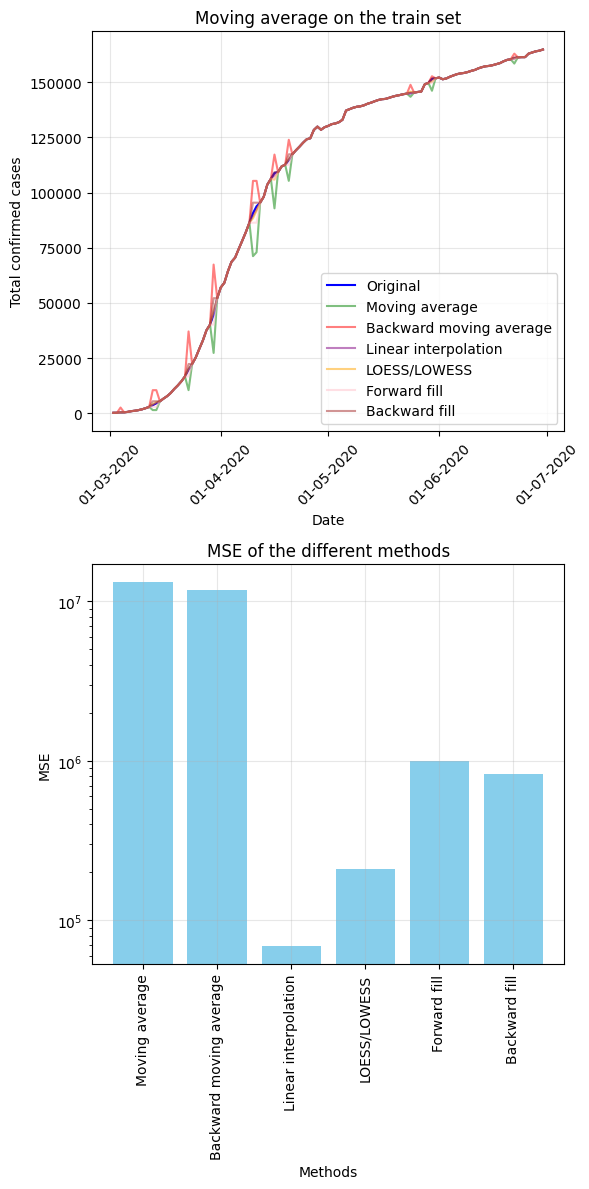

In [164]:
# evaluate the 5 methods using MSE metrics 
mse_mv_avg = mean_squared_error(df_test['total_cas_confirmes'], df_train['mv_avg'])
mse_mv_avg_b = mean_squared_error(df_test['total_cas_confirmes'], df_train['mv_avg_b'])
mse_linear_interp = mean_squared_error(df_test['total_cas_confirmes'], df_train['linear_interp'])
mse_lowess = mean_squared_error(df_test['total_cas_confirmes'], df_train['lowess'])
mse_ffill = mean_squared_error(df_test['total_cas_confirmes'], df_train['ffill'])
mse_bfill = mean_squared_error(df_test['total_cas_confirmes'], df_train['bfill'])

# create a dictionary with the results to use them in an histogram
mse_scores = {
    'Moving average': mse_mv_avg,
    'Backward moving average': mse_mv_avg_b,
    'Linear interpolation': mse_linear_interp,
    'LOESS/LOWESS': mse_lowess,
    'Forward fill': mse_ffill,
    'Backward fill': mse_bfill
}

# plot 
fig, axes = plt.subplots(2, 1, figsize=(6, 12))

# plot the original values
axes[0].plot(df_test['date'], df_test['total_cas_confirmes'], label='Original', color='blue')
# plot the moving average
axes[0].plot(df_train['date'], df_train['mv_avg'], label='Moving average', color='green', alpha=0.5)
# plot the backward moving average
axes[0].plot(df_train['date'], df_train['mv_avg_b'], label='Backward moving average', color='red', alpha=0.5)
# plot the linear interpolation
axes[0].plot(df_train['date'], df_train['linear_interp'], label='Linear interpolation', color='purple', alpha=0.5)
# plot the LOWESS
axes[0].plot(df_train['date'], df_train['lowess'], label='LOESS/LOWESS', color='orange', alpha=0.5)
# plot the forward fill
axes[0].plot(df_train['date'], df_train['ffill'], label='Forward fill', color='pink', alpha=0.5)
# plot the backward fill
axes[0].plot(df_train['date'], df_train['bfill'], label='Backward fill', color='brown', alpha=0.5)

axes[0].set_xlabel("Date")
axes[0].set_ylabel("Total confirmed cases")
axes[0].set_title("Moving average on the train set")
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# plot the histograms of the MSE
axes[1].bar(mse_scores.keys(), mse_scores.values(), color='skyblue')
axes[1].set_title("MSE of the different methods")
axes[1].set_xlabel("Methods")
axes[1].set_ylabel("MSE")
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [165]:
# Make a summary of the MSE scores
print("Summary of the MSE scores:")
print("===================================================\n")
# Order the results
mse_scores = dict(sorted(mse_scores.items(), key=lambda item: item[1]))
# Display the results
for i, (method, mse) in enumerate(mse_scores.items(), start=1):
    print(f"{i} -> {method}: {mse:.2f}")

Summary of the MSE scores:

1 -> Linear interpolation: 69532.19
2 -> LOESS/LOWESS: 208899.37
3 -> Backward fill: 827019.26
4 -> Forward fill: 1004615.83
5 -> Backward moving average: 11779787.86
6 -> Moving average: 13196785.23


## <span style='color:Green'>Conclusion:</span>

As the human eyes suspected, the `Linear interpolation` and the `LOESS/LOWESS`are the 2 best way to fill the missing values in the time serie.

It also appear that there is a huge gap between these 2 methods and the others, going from 82.752 to 425.571 to 10.410.656. 

Even though the number of confirmed cases are very high, which can explain the high values of the MSE, the results are speaking for themselves. 